<a href="https://colab.research.google.com/github/shrisha-rao/zembo-demo/blob/main/Predictive_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from re import VERBOSE
import pandas as pd
from google.cloud import bigquery
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from google.colab import drive  # For saving to Google Drive
from imblearn.over_sampling import SMOTE #Import Smote


########

# GCP project and bucket details
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/zembo-demo-2ebb06d8deb6.json"
########

# Loading data, Preproceing & Imputation

* Load data from bigquery
* Run data checks and prepare data
* Logic to deal with Missing Data: Interpolation & SMOTE



In [ ]:
def load_data_from_bigquery_sql(project_id, dataset_id, table_id):
    """Loads specific columns from BigQuery using SQL into a Pandas DataFrame."""
    client = bigquery.Client(project=project_id)
    query = f"""
        SELECT
            t.Internal_temperature_of_battery,
            t.Surface_temperature_in_the_middle_of_cells,
            t.SOC,
            t.Total_voltage,
            t.Total_current,
            t.Mileage,
            t.Speed_information,
            t.BMS_PCB_board_surface_temperature,
            t.times_100_of_battery_capacity,
            t.Number_of_cycles,
            t.devId,
            t.timestamp as ts
        FROM
            `{project_id}.{dataset_id}.{table_id}` as t
        where t.devID like 'BGU%'
        and t.timestamp is not NULL
        and SOC >= 0 and SOC <= 100
        and Internal_temperature_of_battery >= 0
        and Surface_temperature_in_the_middle_of_cells >= 0
        and Total_voltage >= 0
        and BMS_PCB_board_surface_temperature >= 0
    """
    df = client.query(query).to_dataframe()
    return df

def preprocess_data(df):
    """Preprocesses the DataFrame: converts time columns, handles missing values, etc."""
    if df is None:
        return None

    # Convert time columns to datetime objects if they exist.
    time_cols = ['ts', 'alarmTime', 'old_alarmTime', 'swap_in_date', 'swap_out_date']
    for col in time_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Ensure 'devId' is a string
    if 'devId' in df.columns:
        df['devId'] = df['devId'].astype(str)

    # Coerce other columns to their inferred datatypes, replacing errors with NaN
    for col in df.columns:
        if col not in time_cols and col != 'devId':  # Skip time and devId columns
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce') #Try to convert to numeric
            except:
                try:
                    df[col] = df[col].astype("category") #try to convert to category
                except:
                    pass #if all fails, leave the column as it is.

    return df


def interpolate_missing_values(df):
  # Convert 'ts' to datetime (if not already)
  df['ts'] = pd.to_datetime(df['ts'])
  # Set threshold (e.g., 2 days)
  time_threshold = pd.Timedelta(days=2)
  # Sort by timestamp (if not already sorted)
  df = df.sort_values('ts')
  # Compute time differences
  df['time_diff'] = df['ts'].diff()
  # Apply interpolation only where time difference is below the threshold for all numeric columns
  numeric_cols = df.select_dtypes(include=['number']).columns  # Select numeric columns only
  for col in numeric_cols:
    mask = df[col].isna() & (df['time_diff'] <= time_threshold)  # Only interpolate if within threshold
    df.loc[mask, col] = df[col].interpolate()
  # Drop helper column
  df = df.drop(columns=['time_diff'])
return df


def apply_smote(X_train, y_train):
    """Applies SMOTE to the training data to handle class imbalance."""
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Training & Visualization

In [4]:
def prepare_features_and_target(df):
    """Prepares features and target variable for the model."""
    target = 'Number_of_cycles'
    features = [
        'Internal_temperature_of_battery',
        'Surface_temperature_in_the_middle_of_cells',
        'SOC',
        'Total_voltage',
        'Total_current',
        'Mileage',
        'Speed_information',
        'BMS_PCB_board_surface_temperature',
        'times_100_of_battery_capacity'
    ]
    df_cleaned = df.dropna(subset=[target]) # + features) #remove all rows with nan values in target or features.
    X = df_cleaned[features]
    y = df_cleaned[target]
    return X, y




def train_lightgbm_model(X_train, y_train, X_val, y_val):
    """Trains a LightGBM regression model."""
    model = lgb.LGBMRegressor(objective='regression',
                              random_state=42,
                              n_estimators=5000,
                              verbose=1)
    # model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
    #           eval_metric='l2')

    evals_result = {}  # Store evaluation results

    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              eval_metric='l2',
              callbacks=[lgb.record_evaluation(evals_result)])

    # model.fit(X_train, y_train)

    # Plotting training loss
    lgb.plot_metric(evals_result, metric='l2')

#    lgb.plot_metric(model)
    # Plotting feature importance
    lgb.plot_importance(model, figsize=(5, 4))

    return model

def evaluate_model(model, X_test, y_test):
    """Evaluates the LightGBM model and prints metrics."""
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    return y_test, y_pred

def visualize_results(y_test, y_pred):
    """Visualizes the model's predictions vs. actual values."""
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.35)
    plt.xlabel("Actual Number of Cycles")
    plt.ylabel("Predicted Number of Cycles")
    plt.title("Actual vs. Predicted Number of Cycles")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
             color='red')  # Diagonal line for perfect predictions
    plt.show()

def save_model(model, model_filename, save_to_drive=False, drive_path=""):
    """Saves a trained machine learning model to a file."""
    try:
        if save_to_drive:
            if not drive_path:
                raise ValueError("drive_path must be specified when save_to_drive is True.")

            drive.mount('/content/drive')  # Mount Google Drive

            # Create the directory if it doesn't exist
            import os
            full_dir_path = os.path.join('/content/drive/My Drive/', drive_path)
            os.makedirs(full_dir_path, exist_ok=True)

            full_path = os.path.join(full_dir_path, model_filename)
            joblib.dump(model, full_path)
            print(f"Model saved to Google Drive: {full_path}")
        else:
            joblib.dump(model, model_filename)
            print(f"Model saved locally: {model_filename}")

    except Exception as e:
        print(f"Error saving model: {e}")

# Run Analysis

In [5]:
def main():
    """Main function to orchestrate data loading, preprocessing,
    model training, and evaluation."""
    project_id = "zembo-demo" # GCP project ID
    dataset_id = 'zembo_data'  # BigQuery dataset ID
    table_id = 'battery-data'  # BigQuery table ID

    df = load_data_from_bigquery_sql(project_id, dataset_id, table_id)
    df = preprocess_data(df)
    print('shape:', df.shape)
    X, y = prepare_features_and_target(df)

    # First split into train + (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,
                                                        random_state=42)
    # Then split (validation + test) into validation + test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                    test_size=0.5,
                                                    random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)


    #  # Apply SMOTE to training data
    # # Impute missing values in X_train before applying SMOTE
    # from sklearn.impute import SimpleImputer
    # imputer = SimpleImputer(strategy='mean') # You can change the strategy if needed
    # X_train = imputer.fit_transform(X_train)
    # X_val = imputer.transform(X_val) # Use the same imputer for validation set
    # X_test = imputer.transform(X_test)
    # X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
    # # Apply SMOTE to training data
    # X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)


    print('train shape:', X_train.shape, y_test.shape)
    print('val shape:', X_val.shape, y_val.shape)
    print('test shape:', X_test.shape, y_test.shape)

    model = train_lightgbm_model(X_train, y_train, X_val, y_val)

    save_model(model, "lgbm_model.joblib", save_to_drive=True,
               drive_path="MyModels")

    y_test_values, y_predicted_values = evaluate_model(model, X_test, y_test)
    visualize_results(y_test_values, y_predicted_values)

shape: (5071572, 12)
train shape: (1241260, 9) (310315,)
val shape: (232736, 9) (232736,)
test shape: (310315, 9) (310315,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 1241260, number of used features: 9
[LightGBM] [Info] Start training from score 96.080147
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive: /content/drive/My Drive/MyModels/lgbm_model.joblib
Mean Squared Error: 3334.81
R-squared: 0.29


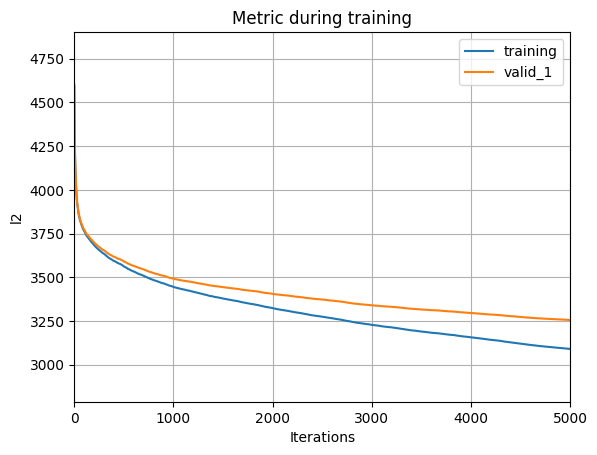

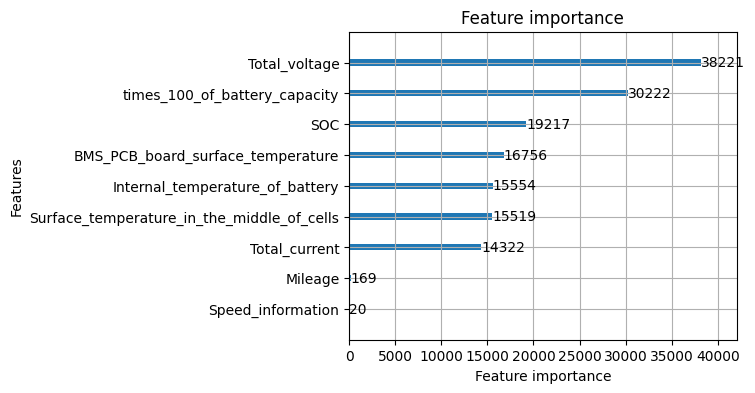

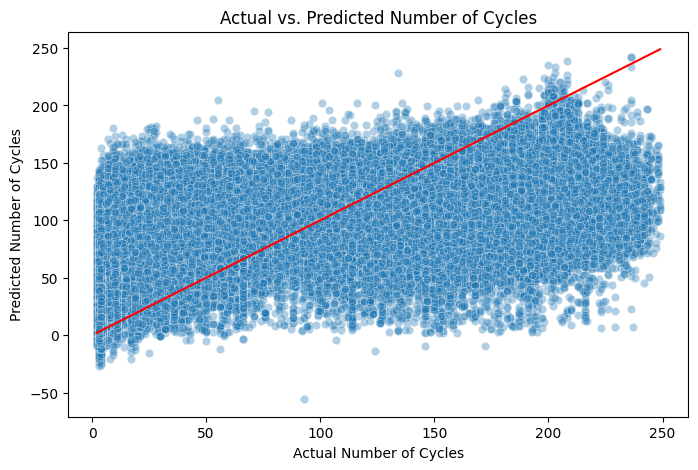

In [6]:
main()